<a href="https://colab.research.google.com/github/asheta66/CNN/blob/main/Bridge_Cracks/Bridge_Cracks_EfficientNetB0_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# ==============================================
# EfficientNetB0 for Bridge Cracks (Single Folder)
# ==============================================

# 1. Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# ----------------------------
# 2. Imports
# ----------------------------
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.applications import EfficientNetB0
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import os

# ----------------------------
# 3. Dataset Path
# ----------------------------
dataset_dir = '/content/drive/MyDrive/Bridge_Cracks'  # contains Positive & Negative subfolders

# ----------------------------
# 4. Detect Image Size Automatically
# ----------------------------
import cv2
sample_class = os.listdir(dataset_dir)[0]
sample_image_path = os.path.join(dataset_dir, sample_class, os.listdir(os.path.join(dataset_dir, sample_class))[0])
sample_image = cv2.imread(sample_image_path)
img_height, img_width = sample_image.shape[:2]
print(f"Detected image size: {img_height}x{img_width}")

# ----------------------------
# 5. Load Dataset with 80/20 Split
# ----------------------------
batch_size = 32
AUTOTUNE = tf.data.AUTOTUNE

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    dataset_dir,
    validation_split=0.2,
    subset="training",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size
)

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    dataset_dir,
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size
)

class_names = train_ds.class_names
num_classes = len(class_names)
print("Classes:", class_names)

# ----------------------------
# 6. Data Augmentation
# ----------------------------
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.2),
    layers.RandomZoom(0.2),
])

train_ds = train_ds.map(lambda x, y: (data_augmentation(x, training=True), y), num_parallel_calls=AUTOTUNE)
train_ds = train_ds.prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.prefetch(buffer_size=AUTOTUNE)

# ----------------------------
# 7. Build Model (Fine-tuning)
# ----------------------------
base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(img_height, img_width, 3))
base_model.trainable = True  # fine-tune all layers

model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(num_classes, activation='softmax')
])

model.compile(optimizer=tf.keras.optimizers.Adam(1e-4),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

# ----------------------------
# 8. Train Model
# ----------------------------
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=10
)


In [ ]:
# ----------------------------
# 9. Extract predictions and true labels
# ----------------------------
def get_labels_and_predictions(dataset, model):
    y_true = []
    y_pred = []
    for images, labels in dataset:
        preds = model.predict(images)
        y_true.extend(labels.numpy())
        y_pred.extend(np.argmax(preds, axis=1))
    return np.array(y_true), np.array(y_pred)

# For training dataset
y_true_train, y_pred_train = get_labels_and_predictions(train_ds, model)

# For validation dataset
y_true_val, y_pred_val = get_labels_and_predictions(val_ds, model)


In [8]:
# ----------------------------
# Define metrics_df function
# ----------------------------
import pandas as pd
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

def metrics_df(y_true, y_pred, dataset_name):
    """Compute key classification metrics and return as DataFrame."""
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, average='weighted')
    recall = recall_score(y_true, y_pred, average='weighted')
    f1 = f1_score(y_true, y_pred, average='weighted')

    # Optional: confusion matrix display
    cm = confusion_matrix(y_true, y_pred)
    print(f"\nConfusion Matrix ({dataset_name}):\n", cm)

    # Return DataFrame with metrics
    df = pd.DataFrame({
        'Dataset': [dataset_name],
        'Accuracy': [accuracy],
        'Precision': [precision],
        'Recall': [recall],
        'F1-Score': [f1]
    })
    return df


In [9]:
# ----------------------------
# 10. Calculate metrics and display as DataFrame
# ----------------------------
df_train_metrics = metrics_df(y_true_train, y_pred_train, "Training")
df_val_metrics = metrics_df(y_true_val, y_pred_val, "Validation")

# Combine into one DataFrame
df_metrics = pd.concat([df_train_metrics, df_val_metrics], ignore_index=True)
df_metrics



Confusion Matrix (Training):
 [[2217    5]
 [   3  833]]

Confusion Matrix (Validation):
 [[550   0]
 [  1 213]]


,Dataset,Accuracy,Precision,Recall,F1-Score
0,Training,0.997384,0.997387,0.997384,0.997385
1,Validation,0.998691,0.998693,0.998691,0.998690


In [10]:
df_metrics

,Dataset,Accuracy,Precision,Recall,F1-Score
0,Training,0.997384,0.997387,0.997384,0.997385
1,Validation,0.998691,0.998693,0.998691,0.998690


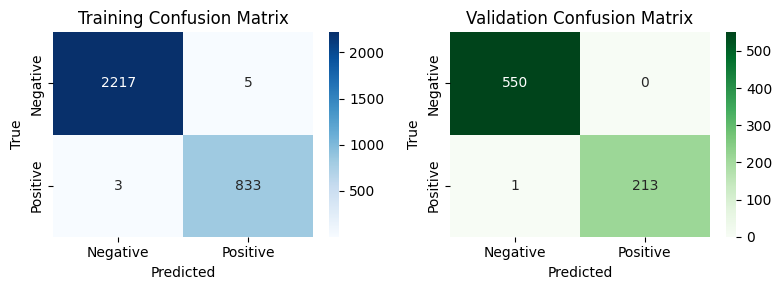

In [11]:
# Confusion matrices
cm_train = confusion_matrix(y_true_train, y_pred_train)
cm_val = confusion_matrix(y_true_val, y_pred_val)

plt.figure(figsize=(8,3))

plt.subplot(1,2,1)
sns.heatmap(cm_train, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title('Training Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')

plt.subplot(1,2,2)
sns.heatmap(cm_val, annot=True, fmt='d', cmap='Greens', xticklabels=class_names, yticklabels=class_names)
plt.title('Validation Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')

plt.tight_layout()
plt.savefig('confusion_matrices_train_val.png')
plt.show()


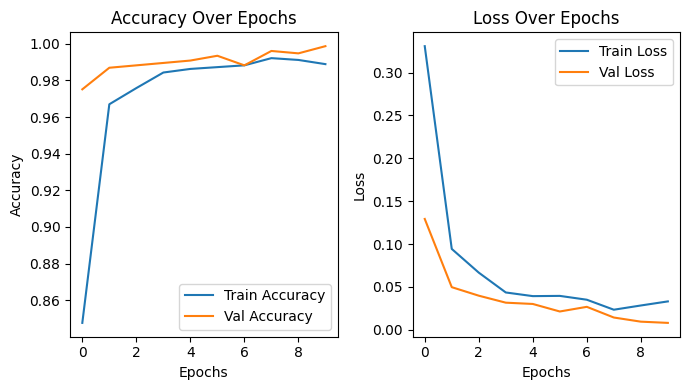

In [12]:
# ----------------------------
# 10. Accuracy & Loss Plots
# ----------------------------
plt.figure(figsize=(7,4))

plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title('Accuracy Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.savefig('accuracy_loss.png')
plt.show()

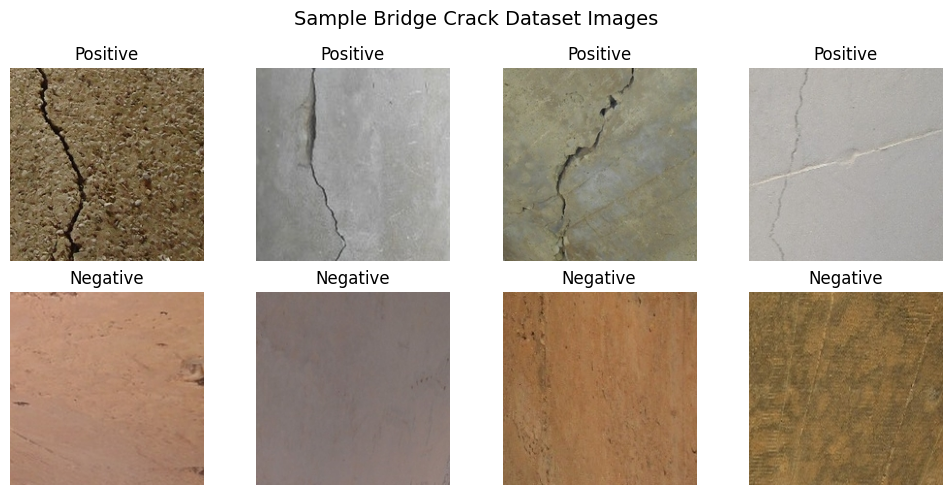

In [13]:
import matplotlib.pyplot as plt
import os
import cv2
import random

# Paths for Positive and Negative subfolders
positive_dir = os.path.join(dataset_dir, "Positive")
negative_dir = os.path.join(dataset_dir, "Negative")

# Pick 4 random samples from each class
positive_samples = random.sample(os.listdir(positive_dir), 4)
negative_samples = random.sample(os.listdir(negative_dir), 4)

# Plot figure
fig, axes = plt.subplots(2, 4, figsize=(10,5))

# First row: Positive cracks
for i, img_name in enumerate(positive_samples):
    img_path = os.path.join(positive_dir, img_name)
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    axes[0, i].imshow(img)
    axes[0, i].set_title("Positive")
    axes[0, i].axis("off")

# Second row: Negative (no cracks)
for i, img_name in enumerate(negative_samples):
    img_path = os.path.join(negative_dir, img_name)
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    axes[1, i].imshow(img)
    axes[1, i].set_title("Negative")
    axes[1, i].axis("off")

plt.suptitle("Sample Bridge Crack Dataset Images", fontsize=14)
plt.tight_layout()
plt.savefig("sample_bridge_crack_images.png")
plt.show()


In [14]:
# ----------------------------
# Original image size
# ----------------------------
import cv2, os, numpy as np

dataset_dir = '/content/drive/MyDrive/Bridge_Cracks'
sample_class = os.listdir(dataset_dir)[0]
sample_image_path = os.path.join(dataset_dir, sample_class, os.listdir(os.path.join(dataset_dir, sample_class))[0])
sample_image = cv2.imread(sample_image_path)
orig_height, orig_width = sample_image.shape[:2]
print(f"Original image size: {orig_height}x{orig_width}")

# ----------------------------
# EfficientNet input size
# ----------------------------
from tensorflow.keras.applications import EfficientNetB0
input_shape = EfficientNetB0(weights='imagenet').input_shape[1:3]  # (224, 224) by default
print(f"EfficientNetB0 input size: {input_shape[0]}x{input_shape[1]}")

# ----------------------------
# Count samples per class
# ----------------------------
from tensorflow.keras.preprocessing import image_dataset_from_directory

batch_size = 32
train_ds = image_dataset_from_directory(
    dataset_dir,
    validation_split=0.2,
    subset="training",
    seed=123,
    image_size=input_shape,
    batch_size=batch_size
)

val_ds = image_dataset_from_directory(
    dataset_dir,
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=input_shape,
    batch_size=batch_size
)

class_names = train_ds.class_names
num_classes = len(class_names)

# Count positive and negative samples
def count_samples(dataset):
    counts = {name: 0 for name in class_names}
    for _, labels in dataset:
        for i, name in enumerate(class_names):
            counts[name] += np.sum(labels.numpy() == i)
    return counts

train_counts = count_samples(train_ds)
val_counts = count_samples(val_ds)

print("Training samples:", train_counts)
print("Validation samples:", val_counts)


Original image size: 200x200
21834768/21834768 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
EfficientNetB0 input size: 224x224
Found 3822 files belonging to 2 classes.
Using 3058 files for training.
Found 3822 files belonging to 2 classes.
Using 764 files for validation.
Training samples: {'Negative': np.int64(2222), 'Positive': np.int64(836)}
Validation samples: {'Negative': np.int64(550), 'Positive': np.int64(214)}


In [15]:
train_count = tf.data.experimental.cardinality(train_ds).numpy() * batch_size
val_count = tf.data.experimental.cardinality(val_ds).numpy() * batch_size

print(f"Number of training batches: {tf.data.experimental.cardinality(train_ds).numpy()}")
print(f"Number of validation batches: {tf.data.experimental.cardinality(val_ds).numpy()}")
print(f"Approximate number of training images: {train_count}")
print(f"Approximate number of validation images: {val_count}")


Number of training batches: 96
Number of validation batches: 24
Approximate number of training images: 3072
Approximate number of validation images: 768


In [16]:
total_images = sum(len(files) for _, _, files in os.walk(dataset_dir) if files)
train_size = int(0.8 * total_images)
val_size = total_images - train_size

print(f"Total images: {total_images}")
print(f"Training images: {train_size}")
print(f"Validation images: {val_size}")


Total images: 3822
Training images: 3057
Validation images: 765


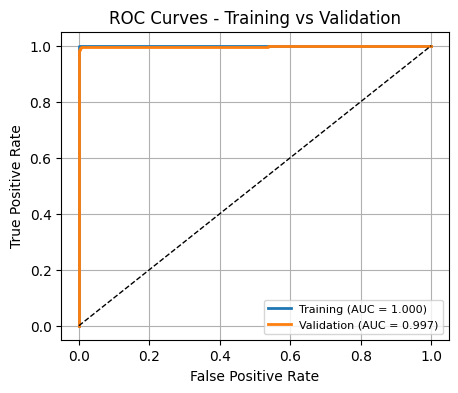

<Figure size 640x480 with 0 Axes>

In [19]:
# ----------------------------
# ROC Curves for Training and Validation (Combined)
# ----------------------------
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt
import numpy as np

def get_probabilities_and_labels(dataset, model):
    """Extract true labels and predicted probabilities from dataset."""
    y_true, y_probs = [], []
    for images, labels in dataset:
        preds = model.predict(images, verbose=0)
        y_true.extend(labels.numpy())
        y_probs.extend(preds)
    return np.array(y_true), np.array(y_probs)


def plot_combined_roc(train_ds, val_ds, model, num_classes):
    """Plot ROC curves for training and validation datasets together."""
    # ---- Get probabilities and true labels ----
    y_true_train, y_probs_train = get_probabilities_and_labels(train_ds, model)
    y_true_val, y_probs_val = get_probabilities_and_labels(val_ds, model)

    plt.figure(figsize=(5, 4))

    if num_classes == 2:
        # Binary classification
        fpr_train, tpr_train, _ = roc_curve(y_true_train, y_probs_train[:, 1])
        fpr_val, tpr_val, _ = roc_curve(y_true_val, y_probs_val[:, 1])
        auc_train = auc(fpr_train, tpr_train)
        auc_val = auc(fpr_val, tpr_val)

        plt.plot(fpr_train, tpr_train, lw=2, label=f"Training (AUC = {auc_train:.3f})")
        plt.plot(fpr_val, tpr_val, lw=2, label=f"Validation (AUC = {auc_val:.3f})")

    else:
        # Multi-class classification (One-vs-Rest)
        y_true_train_bin = label_binarize(y_true_train, classes=range(num_classes))
        y_true_val_bin = label_binarize(y_true_val, classes=range(num_classes))

        for i in range(num_classes):
            fpr_train, tpr_train, _ = roc_curve(y_true_train_bin[:, i], y_probs_train[:, i])
            fpr_val, tpr_val, _ = roc_curve(y_true_val_bin[:, i], y_probs_val[:, i])
            auc_train = auc(fpr_train, tpr_train)
            auc_val = auc(fpr_val, tpr_val)

            plt.plot(fpr_train, tpr_train, lw=2, label=f"Train Class {i} (AUC={auc_train:.3f})")
            plt.plot(fpr_val, tpr_val, lw=2, linestyle='--', label=f"Val Class {i} (AUC={auc_val:.3f})")

    # ---- Final plot formatting ----
    plt.plot([0, 1], [0, 1], 'k--', lw=1)
    plt.title("ROC Curves - Training vs Validation")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.legend(loc="lower right", fontsize=8)
    plt.grid(True)
    plt.show()


# ---- Example usage ----
plot_combined_roc(train_ds, val_ds, model, num_classes)
plt.tight_layout()
plt.savefig("ROC_curves.png")
plt.show()
